# Uber Trip Classification

Tujuan :
* Membuat model yang dapat memprediksi apabila terjadi kesalahan dalam pencatatan data perjalanan Uber.

Masalah :
* Tidak ada kolom label untuk menjadi target.
* Data tanggal tidak ada notasi AM / PM.

Landasan Teori :
* Dengan asumsi batas kecepatan di kawasan perkotaan adalah 50 km/jam, kawasan permukiman adalah 30 km/jam, kawasan jalanan antar kota paling rendah adalah 60 km/jam dan dalam kota paling cepat adalah 80 km/jam. ([Kumparan](https://kumparan.com/info-otomotif/batas-kecepatan-untuk-dalam-kota-begini-aturannya-1xvq35hLvXP/3), [Otomotif Kompas](https://otomotif.kompas.com/read/2022/06/20/191100215/batas-kecepatan-berkendara-di-jalan-tol-tidak-semua-sama))
* Waktu tunggu maksimal adalah 5 menit. ([therideshareguy](https://therideshareguy.com/uber-extends-wait-time/))


Label Feature Description :
* 0 = False
* 1 = True

## Import Libs

In [1]:
import pandas as pd
import os
from datetime import date, datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from geopy.distance import distance
import math
import re

## Load Data

In [2]:
bog_path = os.path.join("dataset", "bog_clean.csv")
mex_path = os.path.join("dataset", "mex_clean.csv")
uio_path = os.path.join("dataset", "uio_clean.csv")

In [3]:
bog_df = pd.read_csv(bog_path)
mex_df = pd.read_csv(mex_path)
uio_df = pd.read_csv(uio_path)

## Explore Data

In [6]:
print(bog_df.shape)
print(mex_df.shape)
print(uio_df.shape)

(3063, 12)
(12694, 12)
(32366, 12)


In [5]:
# check bog unique value
for i in bog_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {bog_df[i].nunique()}")

id : 3063
vendor_id : 5
store_and_fwd_flag : 1


In [8]:
# check mex unique value
for i in mex_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {mex_df[i].nunique()}")

id : 12694
vendor_id : 7
store_and_fwd_flag : 1


In [9]:
# check uio unique value
for i in uio_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {uio_df[i].nunique()}")

id : 32366
vendor_id : 4
store_and_fwd_flag : 1


Dapat disimpulkan bahwa tidak ada dupilkat dari kolom `id`, `store_and_fwd_flag` hanya memiliki satu nilai unik dan `datetime` masih dalam tipe data objek pada setiap dataset

In [10]:
uber_df = pd.concat([bog_df, mex_df, uio_df], ignore_index=True)

In [11]:
uber_df = uber_df.drop(["id", "store_and_fwd_flag"], axis=1)

In [12]:
uber_df.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,48123.0,-8.365820e+01,9.327967e+00,-1.089851e+02,-99.055060,-78.499710,-78.477681,-7.382972e+01
pickup_latitude,48123.0,5.283597e+00,8.522385e+00,-3.454279e+00,-0.198366,-0.149986,19.281108,2.575296e+01
dropoff_longitude,48123.0,-8.365799e+01,9.326627e+00,-1.089874e+02,-99.040406,-78.498237,-78.479051,-7.361570e+01
dropoff_latitude,48123.0,5.282378e+00,8.524195e+00,-3.574739e+00,-0.201981,-0.151495,19.279311,2.578106e+01
trip_duration,48123.0,3.981179e+04,5.155872e+05,-3.887110e+05,497.000000,944.000000,1947.500000,7.002605e+07
dist_meters,48123.0,-3.774470e+04,1.695578e+07,-2.147484e+09,2032.000000,4133.000000,7880.000000,2.147484e+09
wait_sec,48123.0,1.519156e+07,6.005287e+08,0.000000e+00,101.000000,244.000000,534.000000,9.516306e+10


Terdapat nilai yang tidak realistis minimal dan maksimal pada `trip_duration`, `dist_meters`, dan `wait_sec	`

### Visualisasi Data

Membuat visualisasi untuk menjelaskan sebaran data yang tidak realistis / bermasalah

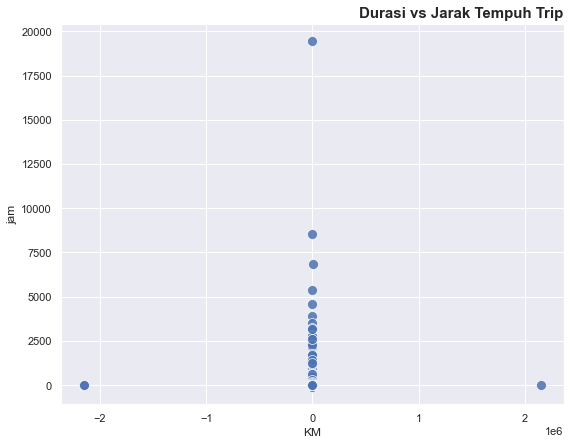

In [14]:
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=uber_df,
    x=uber_df.dist_meters/1000,
    y=uber_df.trip_duration/3600,
    s=100,
    alpha=0.85
)

plt.title("Durasi vs Jarak Tempuh Trip",
    loc="right",
    fontweight="bold",
    size=15
)

plt.xlabel("KM")
plt.ylabel("jam")
plt.show()

Waktu dan jarak tempuh seharusnya tidak ada yang negatif, waktu tempuh paling lama adalah 1.94e+4 jam, serta jarak tempuh paling lama adalah 2.15e+6 KM.

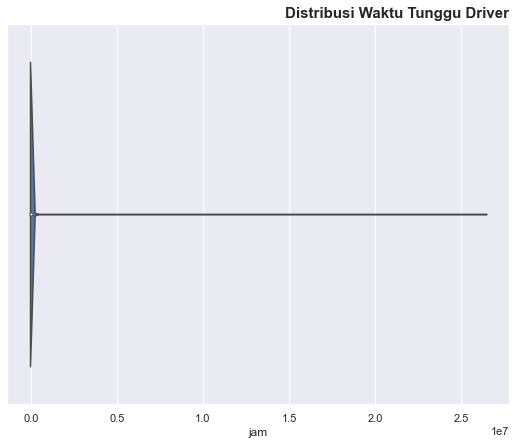

In [15]:
plt.figure(figsize=(9, 7))
sns.violinplot(x=uber_df["wait_sec"]/3600)

plt.title(
    "Distribusi Waktu Tunggu Driver",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("jam")
plt.show()

Waktu driver menunggu penumpang juga terlampau lama yaitu 2.6e+7 jam

In [16]:
# calculate speed in km/h
speed_kmph = (uber_df["dist_meters"] / 1000) / (uber_df["trip_duration"] / 3600)
speed_kmph.describe()

count    4.812300e+04
mean    -2.554891e+02
std      7.592147e+04
min     -1.498244e+07
25%      9.437383e+00
50%      1.642021e+01
75%      2.272778e+01
max      5.942307e+06
dtype: float64

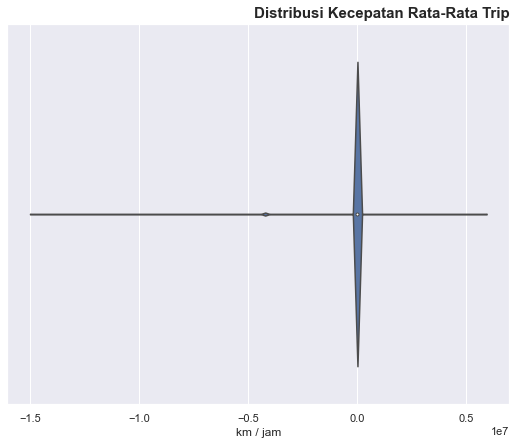

In [17]:
# plot kmph distribution
plt.figure(figsize=(9, 7))
sns.violinplot(x=speed_kmph)

plt.title(
    "Distribusi Kecepatan Rata-Rata Trip",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km / jam")
plt.show()

Kecepatan kendaraan juga terdapat data negatif dan yang paling cepat adalah 5.94e+06

In [18]:
# mengubah format date and time
uber_df["pickup_datetime"] = pd.to_datetime(uber_df["pickup_datetime"], format="%Y/%m/%d %H:%M:%S")
uber_df["dropoff_datetime"] = pd.to_datetime(uber_df["dropoff_datetime"], format="%Y/%m/%d %H:%M:%S")

In [19]:
# check max and minimum time
print("pickup & dropoff maximum time is {} {}".format(
    uber_df["pickup_datetime"].dt.time.max(), 
    uber_df["dropoff_datetime"].dt.time.max())
)

print("pickup & dropoff minimum time is {} {}".format(
    uber_df["pickup_datetime"].dt.time.min(), 
    uber_df["dropoff_datetime"].dt.time.min())
)

pickup & dropoff maximum time is 12:59:59 12:59:59
pickup & dropoff minimum time is 01:00:01 01:00:01


Waktu perjalanan saat diterima dan selesai tidak dalam format 24H serta tidak terdapat notasi AM / PM 

## CLEANING, PREPROCESSING, FEATURE ENGINEERING

### *_datetime
Menghilangkan time dari tanggal untuk menghindari kesalahan dalam kalkulasi

In [20]:
uber_df["pickup_date"] = pd.to_datetime(uber_df["pickup_datetime"]).dt.date
uber_df["dropoff_date"] = pd.to_datetime(uber_df["dropoff_datetime"]).dt.date
uber_df = uber_df.drop(["pickup_datetime", "dropoff_datetime"], axis=1)

Menghitung lama perjalanan berdasarkan hari

In [21]:
def day_delta(df) :
    day = []
    for i in range(len(df)) :
        delta = (df.dropoff_date[i] - df.pickup_date[i]).days
        day.append(int(delta))
    return day

In [22]:
uber_df["day_delta"] = day_delta(uber_df)

In [23]:
uber_df = uber_df.drop(["pickup_date", "dropoff_date"], axis=1)

### dist_meters
Membuat estimasi jarak sesungguhnya

In [24]:
def geodesic(p_lon, p_lat, d_lon, d_lat) :
    # calculate distance using geodesic method
    # COEF is a coeficient for calibrating the geodesic result to nearly matches OSRM driving distance
    # distance in meters
    COEF = 1.5165
    pickup = (p_lat, p_lon)
    dropoff = (d_lat, d_lon)
    result = distance(pickup, dropoff).km
    return result * COEF * 1000

def distance_estimator(df) :
    # calculate the duration then append to est_duration
    # using geodesic
    # name the estimated distance to est_meters
    distance = []
    for i in range(len(df)) :
        PICKUP_LONG = df.pickup_longitude[i]
        PICKUP_LAT = df.pickup_latitude[i]
        DROPOFF_LONG = df.dropoff_longitude[i]
        DROPOFF_LAT = df.dropoff_latitude[i]
        result = geodesic(PICKUP_LONG, PICKUP_LAT, DROPOFF_LONG, DROPOFF_LAT)
        distance.append(math.ceil(result))
    return distance

In [25]:
uber_df["est_meters"] = distance_estimator(uber_df)

In [26]:
uber_df = uber_df.drop(["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], axis=1)

### trip_duration
Membuat estimasi durasi perjalanan sesungguhnya


In [27]:
def duration_estimator(df) :
    # rata-rata kecepatan 40 km/h
    time = []
    v = 40 * (1000/3600) # average speed in m/s
    for i in range(len(df)) :
        d = df.est_meters[i]
        t = d / v # time travel in seconds
        time.append(math.ceil(t))
    return time

In [28]:
uber_df["est_duration"] = duration_estimator(uber_df)

### vendor_id
Mengambil tipe layanan uber

In [29]:
uber_df["vendor_id"].unique()

array(['Bogotá', 'Bogotá UberX', 'Bogota UberBlack', 'Bogotá UberVan',
       'Bogotá UberAngel', 'México DF Taxi de Sitio',
       'México DF Taxi Libre', 'México DF Radio Taxi', 'México DF UberX',
       'México DF UberXL', 'México DF UberSUV', 'México DF UberBlack',
       'Quito', 'Quito Cabify Lite', 'Quito Cabify Executive',
       'Quito UberX'], dtype=object)

Terdapat beberapa nama layanan yang tidak tersedia pada laman website uber akan dijadikan taxi dan sisanya akan disesuaikan dengan layanan ekivalennya

In [30]:
def services_extractor(df) :
    # extract services name from vendor_id and map the services based in 2022
    # some normal services is not available in 2022, it'll be taxi service instead
    # uberangel is exclusive to colombia, it'll be uberblack service instead
    # ubersuv will be uberxl
    SERVICE_NAME = re.compile(
        r"taxi|uberxl|uberx|uberblack|ubervan|uberangel|ubersuv"
    )
    df["vendor_id"] = df["vendor_id"].str.lower()
    service = []
    for i in range(len(df)) :
        extract = SERVICE_NAME.search(df.vendor_id[i])
        if extract != None :
            ext_group = extract.group()
            if (ext_group  == "ubervan") or (ext_group == "ubersuv"):
                service.append("uberxl")
            elif ext_group == "uberangel" :
                service.append("uberblack")
            else : 
                service.append(ext_group)
        else :
            service.append("taxi")
    return service

In [31]:
uber_df["service"] = services_extractor(uber_df)

In [32]:
uber_df["service"].unique()

array(['taxi', 'uberx', 'uberblack', 'uberxl'], dtype=object)

In [33]:
uber_df = uber_df.drop("vendor_id", axis=1)

### DEFINE TARGET VARIABLE / LABELING

Dalam project Uber Trip Classification bertujuan untuk melakukan prediksi terhadap kesalahan aplikasi menyimpan data perjalanan yang diakibatkan driver lupa mengakhiri perjalanan pada aplikasi, dan mengakibatkan kesalahan dalam penagihan harga kepada customer.

Variabel `est_meters`, `est_duration` dapat dijadikan pembanding kebenaran terhadap variabel `dist_meters` dan `trip_duration` yang terdapat kesalahan dalam peyimpanan.

Perbandingan menggunakan batas atas dan batas bawah yang terdiri dari toleransi perjalanan lebih lama atau lebih cepat yang diakibatkan oleh kecepatan mobil dan keadaan lalu lintas yang tidak menentu, batas waktu driver menunggu selama 5 menit, minimal jarak perjalanan yang dianggap valid adalah 1 KM, serta perjalanan yang terhitung 1 hari mungkin valid apabila terjadi pada tengah malam namun 2 hari sudah pasti tidak valid.

In [70]:
def labeler(df) :
    label = []
    DIST_MIN = 1000
    WT = 5 * 60
    for i in range(len(df)) :
        DLB = df.est_meters[i] * 0.5 # might be closer
        DHB = df.est_meters[i] * 1.5 # might be further
        TLB = df.est_duration[i] * 0.4 # might be faster (~ 40km/h - 80km/h)
        THB = df.est_duration[i] * 4 * 1.5 # might be slower (~ 10km/h - 40km/h) and 50% longer
        DD = df.day_delta[i]
        if DD > 1 :
            label.append(0)
        elif (df.est_meters[i] < DIST_MIN) or (df.wait_sec[i] > WT): 
            label.append(0)
        elif (df.dist_meters[i] > DLB) and (df.dist_meters[i] < DHB) :
            if (df.trip_duration[i] > TLB) and (df.trip_duration[i] < THB) :
                label.append(1)
            else :
                label.append(0)
        else :
            label.append(0)
    return label

In [71]:
uber_df["label"] = labeler(uber_df)

In [72]:
for i in range(uber_df["label"].nunique()) :
    print("label {} : {}".format(i, list(uber_df["label"].values).count(i)))

label 0 : 30653
label 1 : 17470


In [74]:
uber_df = uber_df.drop(["est_meters", "est_duration"], axis=1)